### Question 1 ( 10pts+5pts+10pts+5pts+10pts)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

1) We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

2) Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

3) When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following outputs:

1) The kernel after parameter optimization and fitting to the observed data.

2) The log marginal likelihood of the training data.  

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.


In [24]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [21]:
data1=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/PittsburghTrafficCounts.csv")

In [23]:
# take natural log and remove mean from data
data1['logcount'] = np.log(data1.loc[:, 'AvgDailyTrafficCount'])
data1['zerologcount'] = data1.loc[:, 'logcount'] - np.mean(data1.loc[:, 'logcount'])
data1.columns = ['lng', 'lat', 'count', 'logcount', 'zerologcount']
data1.head()

,lng,lat,count,logcount,zerologcount
0,-80.278366,40.468606,84.0,4.430817,-3.977526
1,-80.162117,40.384598,95.0,4.553877,-3.854466
2,-80.221205,40.366778,97.0,4.574711,-3.833632
3,-80.142455,40.622084,111.0,4.709530,-3.698812
4,-80.131975,40.544915,125.0,4.828314,-3.580029


In [25]:
X = data1.loc[:, ['lat', 'lng']]
y = data1.loc[:, 'zerologcount']

In [31]:
# use RBF kernel with an additional noise kernel
kernel = RBF(length_scale=(1.0, 1.0), length_scale_bounds=(1e-5, 1e5)) \
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))

# fit the GP regression
gp = GPR(kernel=kernel, n_restarts_optimizer=10, random_state=12)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=12)

In [36]:
# report kernel specs and log marginal liklihood
print 'for kernel:\n{}\n\nlog marginal liklihood:\n{}'\
    .format(gp.kernel_, gp.log_marginal_likelihood_value_)

for kernel:
RBF(length_scale=[0.0552, 0.0404]) + WhiteKernel(noise_level=0.58)

log marginal liklihood:
-1370.78004903


In [50]:
print 'min lat: {}'.format(min(data1.lat))
print 'max lat: {}'.format(max(data1.lat))
print 'lat range: {}\n'.format(max(data1.lat) - min(data1.lat))

print 'min lng: {}'.format(min(data1.lng))
print 'max lng: {}'.format(max(data1.lng))
print 'lng range: {}'.format(max(data1.lng) - min(data1.lng))

min lat: 40.19890043
max lat: 40.68171776
lat range: 0.48281733

min lng: -80.31494883
max lng: -79.68191838
lng range: 0.63303045


In [96]:
lat_range = np.arange(min(data1.lat),
                      max(data1.lat) + ((max(data1.lat) - min(data1.lat)) / 50),
                      (max(data1.lat) - min(data1.lat)) / 50) #100

lng_range = np.arange(min(data1.lng),
                      max(data1.lng) + ((max(data1.lng) - min(data1.lng)) / 65),
                      (max(data1.lng) - min(data1.lng)) / 65) # 130

# make a meshgrid of lat and lng throughout domain
latlat, lnglng = np.meshgrid(lat_range, lng_range)

In [98]:
# predict traffic counts (log, zero centered still) throughout mesh
predict_count = np.vectorize(lambda lat, lng: gp.predict([[lat, lng]], return_std=True))
pred, sigma = predict_count(latlat, lnglng)

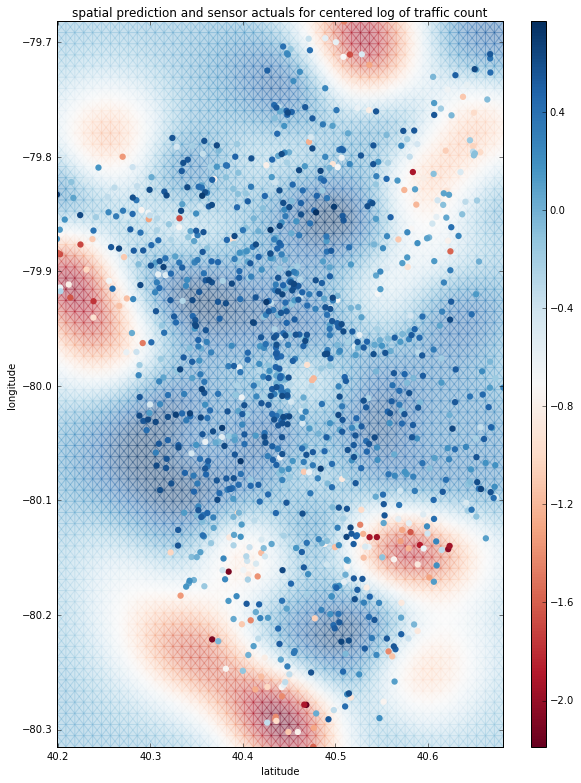

In [226]:
fig, ax = plt.subplots()
fig.set_size_inches(10,13)
ax.set_xlim([min(data1.lat), max(data1.lat)])
ax.set_ylim([min(data1.lng), max(data1.lng)])
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('spatial prediction and sensor actuals for centered log of traffic count')

# plotting predictions throughout grid
ax.pcolormesh(latlat,
              lnglng,
              pred,
              cmap='RdBu',
              shading='gouraud',
              edgecolors=None,
              alpha=0.4)

# overlay real observations from sensors, using same colormap
ax.scatter(data1.lat,
           data1.lng, 
           c=data1.zerologcount,
           cmap='RdBu',
           s=40,
           lw=0,
           alpha=1)

# set up the colorbar
s = plt.cm.ScalarMappable()
s.set_cmap(plt.cm.RdBu)
s.set_array(pred)

fig.colorbar(s, aspect=50)
plt.show()

In [197]:
# get predicted values at sensor locations
sensor_predict, sensor_sigma = gp.predict(X, return_std=True)

# estbalish 2-sigma upper and lower bounds
upper = sensor_predict + 2*sensor_sigma
lower = sensor_predict - 2*sensor_sigma
data1['upper'] = upper
data1['lower'] = lower

print """Percent of sensors having counts more than two SD higher,
or less than 2 SD lower, than the model predicts:"""
print '{}%'.format(round(float(sum(y < lower) + sum(y > upper)) * 100 / len(y), 2))

Percent of sensors having counts more than two SD higher,
or less than 2 SD lower, than the model predicts:
4.13%


In [223]:
# function to categorize observations as within range, or outside of 2sigma of prediction
def categorize(row):
    if row['zerologcount'] < row['lower']:
        return 'obs. < pred. - 2sigma'
    elif row['zerologcount'] > row['upper']:
        return 'obs. > pred. + 2sigma'
    else: 
        return 'obs. within bounds'

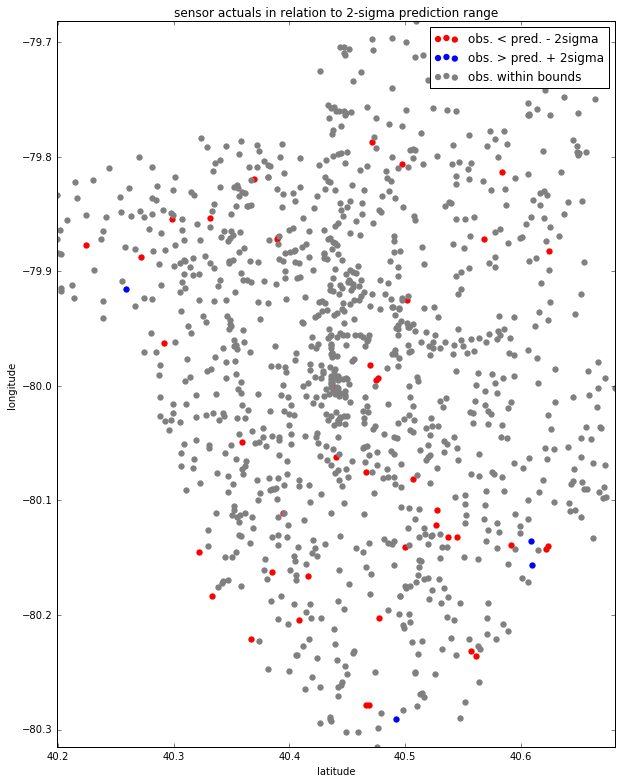

In [227]:
fig, ax = plt.subplots()
fig.set_size_inches(10,13)
ax.set_xlim([min(data1.lat), max(data1.lat)])
ax.set_ylim([min(data1.lng), max(data1.lng)])
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('sensor actuals in relation to 2-sigma prediction range')

# map categories to colors
colors = {'obs. < pred. - 2sigma': 'red',
          'obs. > pred. + 2sigma': 'blue',
          'obs. within bounds': 'grey'}

data1['category'] = data1.apply(categorize, axis=1)
grouped = data1.groupby('category')
for cat, group in grouped:
    ax.scatter(group.lat,
               group.lng, 
               label=cat,
               c=colors[cat],
               s=40,
               lw=0,
               alpha=1)
plt.legend()
plt.show()

### Question 2: Cluster-based anomaly detection (10pts, 2.5pts+2.5pts+2.5pts+2.5pts)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

![cluster_detection](cluster_anom.jpg)


(1, 0)		Anomaly / Not Anomaly

    - very dense and tight cluster
    - point is 10 sigma from cluster center --> definitely ANOMALY

(35, 5)		Anomaly / Not Anomaly

    - point sits right on cluster center
    - very sparse and large cluster... if we used global density comparisons, this point could
    conceivably be labelled as an anomaly
    - but assuming we would choose a good method (local density), and the point is right
    on cluster center, it should be NOT ANOMALY

(15, 19)	Anomaly / Not Anomaly

    - 1 sigma from cluster center
    - the cluster itself only has two points... it's possible that this 
    whole cluster would be labelled as an anomaly if the chosen method allowed for that
    - even with density methods, these points would score very low
    - only method that would save this cluster as "normal" would be a KNN approach with k >= 3
    - so, very dependent on method, but I'd say ANOMALY (along with the cluster's other 2 points)

(10, 11)	Anomaly / Not Anomaly

    - 1 sigma from cluster center
    - quite a dense cluster, with lots of points
    - likely that this point would fall into the cluster
    - global density would keep this as a normal point (relative to cluster B and C)
    - local density and most distance based methods would probably also keep this point
    as normal, considering that it's within 1 SD of the cluster center, and there are lots
    of point in the cluster, meaning that it should have several close neigbors
    - probably NOT ANOMALY
    


### Question 3: Anomaly detection (5pts+10pts+10pts+10pts+10pts+5pts)

For this question, use the "County Health Indicators dataset" provided to identify the most anomalous counties. Please list the top 5 most anomalous counties by following models: 

Data preprocessing hints:
- a. convert the strings to float(except the first column).
- b. drop all nan's. 

(1) Pick up features 
$["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'", "'Average Daily PM2.5'"]$
and use pd.cut() to categorize each feature into 5 categories: 0,1,2,3,4. 

a. Use HillClimbSearch and BicScore to learn the baysian network structure. 

b. Which 5 counties have lowest logliklihood values? Please show the counties' name with its loglikelihood values. 

(2) Cluster based anomaly detection.

a.Cluster with k-means. Please set k= 3.Compute each record's distance to the nearest cluster center and report the five counties which have top five highest distances.

b. Cluster with Gaussian Mixture. Please repeat (2)a but use loglikelihood for each record.

(3) Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you choose. 

(4) Compare and contrast the results from different models, and provide some intuitions on why each county was found to be anomalous.  




In [499]:
data3 = pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/2016CountyHealthIndicators.csv")
data3.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [500]:
# remove weird slashes and extra quotes
def clean_cols(name):
    return name.replace("\\% ", "% ").replace("'", "")

data3.columns = data3.columns.map(clean_cols)

In [501]:
data3.columns

Index([u'County', u'% Reporting Fair/Poor Health',
       u'Physically Unhealthy Days Per Month',
       u'Mentally Unhealthy Days Per Month', u'% Low birth weight births',
       u'% Smokers', u'% Obese', u'Food Environment Index',
       u'% Physically Inactive', u'% With Access To Exercise',
       u'% Excessive Drinking', u'% Alcohol-Impaired Driving Deaths',
       u'Chlamydia Rate', u'Teen Birth Rate', u'% Uninsured',
       u'Preventable Hosp. Rate', u'% Dibetics receiving HbA1c',
       u'% Mammography', u'Graduation Rate', u'% Some College',
       u'% Unemployed', u'% Children in Poverty', u'80/20 Income Ratio',
       u'% Single-Parent Households', u'Association Rate',
       u'Violent Crime Rate', u'Injury Death Rate', u'Average Daily PM2.5',
       u'% Severe Housing Problems', u'% Drive Alone',
       u'% Long Commute - Drives Alone'],
      dtype='object')

In [502]:
# replace ? with np.nan
data3.replace('?', np.nan, inplace=True)

In [503]:
# cast data to floats
for col in data3.columns[1:]:
    data3.loc[:, col] = data3.loc[:, col].map(float) 
    # how many nans?
    print '{}: {} NaNs'.format(col, sum(np.isnan(data3[col])))

% Reporting Fair/Poor Health: 1 NaNs
Physically Unhealthy Days Per Month: 1 NaNs
Mentally Unhealthy Days Per Month: 1 NaNs
% Low birth weight births: 99 NaNs
% Smokers: 1 NaNs
% Obese: 0 NaNs
Food Environment Index: 0 NaNs
% Physically Inactive: 0 NaNs
% With Access To Exercise: 74 NaNs
% Excessive Drinking: 1 NaNs
% Alcohol-Impaired Driving Deaths: 23 NaNs
Chlamydia Rate: 180 NaNs
Teen Birth Rate: 99 NaNs
% Uninsured: 1 NaNs
Preventable Hosp. Rate: 83 NaNs
% Dibetics receiving HbA1c: 42 NaNs
% Mammography: 112 NaNs
Graduation Rate: 504 NaNs
% Some College: 1 NaNs
% Unemployed: 2 NaNs
% Children in Poverty: 2 NaNs
80/20 Income Ratio: 1 NaNs
% Single-Parent Households: 2 NaNs
Association Rate: 0 NaNs
Violent Crime Rate: 167 NaNs
Injury Death Rate: 117 NaNs
Average Daily PM2.5: 33 NaNs
% Severe Housing Problems: 0 NaNs
% Drive Alone: 1 NaNs
% Long Commute - Drives Alone: 1 NaNs


In [504]:
# drop any records with NaN
data3.dropna(axis=0, how='any', inplace=True)
data3.reset_index(inplace=True, drop=True)

#### Bayesian Network

In [505]:
# get subset for bayesian network method
data3_bn = data3.loc[:, ['% Smokers',
                         '% Obese',
                         'Violent Crime Rate',
                         '80/20 Income Ratio',
                         '% Children in Poverty',
                         'Average Daily PM2.5']]

In [506]:
# cut all six features into 5 equally sized bins
for col in data3_bn.columns:
    data3_bn.loc[:, col] = pd.cut(data3_bn.loc[:, col], 5, labels=[0,1,2,3,4])

data3_bn.head()

,% Smokers,% Obese,Violent Crime Rate,80/20 Income Ratio,% Children in Poverty,Average Daily PM2.5
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,2,3


In [507]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

In [508]:
# find bayesian network edges using hill climb
hc = HillClimbSearch(data3_bn, scoring_method=BicScore(data3_bn))
best_model = hc.estimate()
print(best_model.edges())

[('% Children in Poverty', 'Violent Crime Rate'), ('% Children in Poverty', '% Smokers'), ('% Smokers', '% Obese'), ('% Smokers', 'Average Daily PM2.5'), ('80/20 Income Ratio', '% Children in Poverty')]


In [509]:
# fit the structure's CPDs
model = BayesianModel(best_model.edges())
model.fit(data3_bn, estimator=MaximumLikelihoodEstimator)

In [510]:
# allows variable inference based on parent observations
infer = VariableElimination(model)

In [511]:
# this function borrowed from the lab session; 
# computes total log-liklihood for a given record of variable observations
def logLiklihood(row, infer):
    
    smoke = row['% Smokers']
    obese = row['% Obese']
    crime = row['Violent Crime Rate']
    income = row['80/20 Income Ratio']
    poverty = row['% Children in Poverty']
    pm = row['Average Daily PM2.5']
    
    return np.log((infer.query(['% Children in Poverty'], evidence={'80/20 Income Ratio': income})['% Children in Poverty']).values[poverty])\
        + np.log((infer.query(['Violent Crime Rate'], evidence={'% Children in Poverty': poverty})['Violent Crime Rate']).values[crime])\
        + np.log((infer.query(['% Smokers'], evidence={'% Children in Poverty': poverty})['% Smokers']).values[smoke])\
        + np.log((infer.query(['Average Daily PM2.5'], evidence={'% Smokers': smoke}) ['Average Daily PM2.5']).values[pm])\
        + np.log((infer.query(['% Obese'], evidence={'% Smokers': smoke}) ['% Obese']).values[obese])


In [512]:
# compute log-liklihoods for all counties, and get most anomalous five
llhoods = data3_bn.apply(lambda row: logLiklihood(row, infer), axis=1)
model_top5 = llhoods.sort_values()[:5]

In [515]:
# display results
results_bn = pd.concat([data3.loc[model_top5.index, 'County'], model_top5], axis=1)
results_bn.columns = ['County', 'log-liklihood']
results_bn

,County,log-liklihood
154,"Fresno, California",-12.055426
1675,"Carter, Oklahoma",-11.768670
1071,"Saginaw, Michigan",-11.565248
1313,"Silver Bow, Montana",-11.457105
342,"Clayton, Georgia",-11.220140


#### K-means (original dataset)

In [488]:
from sklearn.cluster import KMeans

In [516]:
data3.head()

,County,% Reporting Fair/Poor Health,Physically Unhealthy Days Per Month,Mentally Unhealthy Days Per Month,% Low birth weight births,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access To Exercise,...,% Children in Poverty,80/20 Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [517]:
# variable standardization for clustering
for col in data3.columns[1:]:
    mn = np.mean(data3.loc[:, col])
    sd = np.std(data3.loc[:, col])
    data3.loc[:, col] = data3.loc[:, col].map(lambda val: (val - mn) / sd) 

In [518]:
KM = KMeans(n_clusters=3, random_state=12)

# exclude 'county' from clustering
clusters = KM.fit_predict(data3.iloc[:, 1:])
distances = pd.DataFrame(KM.transform(data3.iloc[:, 1:]))

In [519]:
# append the cluster label to which the record was assigned
distances = pd.concat([distances, pd.Series(clusters)], axis=1)
distances.columns = ['0_distance', '1_distance', '2_distance', 'assigned_cluster']

In [520]:
# create a new column representing the distance to assigned cluster
# should just be smallest distance of the three
distances.loc[:, 'score'] = distances.apply(
    lambda row: row[str(int(row['assigned_cluster'])) + '_distance'], axis=1)

In [521]:
km_top5 = distances.sort_values("score", ascending=False)[:5]

In [522]:
# display results
results_km = pd.concat([data3.loc[km_top5.index, 'County'], km_top5.score], axis=1)
results_km.columns = ['County', 'distance to cluster center']
results_km

,County,distance to cluster center
1890,"Shannon, South Dakota",22.678278
1444,"New York, New York",15.676365
66,"Apache, Arizona",14.317886
1417,"Bronx, New York",13.668157
1437,"Kings, New York",13.050039


#### K-means (with binned bayesian network subset)

In [524]:
KM = KMeans(n_clusters=3, random_state=12)

# exclude 'county' from clustering
clusters = KM.fit_predict(data3_bn)
distances = pd.DataFrame(KM.transform(data3_bn))

In [525]:
# append the cluster label to which the record was assigned
distances = pd.concat([distances, pd.Series(clusters)], axis=1)
distances.columns = ['0_distance', '1_distance', '2_distance', 'assigned_cluster']

In [526]:
# create a new column representing the distance to assigned cluster
# should just be smallest distance of the three
distances.loc[:, 'score'] = distances.apply(
    lambda row: row[str(int(row['assigned_cluster'])) + '_distance'], axis=1)

In [527]:
km_top5 = distances.sort_values("score", ascending=False)[:5]

In [528]:
# display results
results_km = pd.concat([data3.loc[km_top5.index, 'County'], km_top5.score], axis=1)
results_km.columns = ['County', 'distance to cluster center']
results_km

,County,distance to cluster center
1577,"Rolette, North Dakota",4.183318
2158,"Willacy, Texas",4.088783
1444,"New York, New York",3.989469
1007,"Suffolk, Massachusetts",3.712579
1294,"St. Louis City, Missouri",3.695595


#### Gaussian Mixture (original dataset)

In [530]:
from sklearn.mixture import GaussianMixture

In [531]:
GM = GaussianMixture(n_components=3, random_state=12)
GM.fit(data3.iloc[:, 1:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=12, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [535]:
# use log-liklihood to get top 5 LEAST likely counties, according to GM
gm_top5 = pd.DataFrame(GM.score_samples(data3.iloc[:, 1:])).sort_values(0)[:5]

In [536]:
# display results
results_gm = pd.concat([data3.loc[gm_top5.index, 'County'], gm_top5], axis=1)
results_gm.columns = ['County', 'liklihood score']
results_gm

,County,liklihood score
1890,"Shannon, South Dakota",-135.093532
1444,"New York, New York",-76.016828
1577,"Rolette, North Dakota",-75.060786
157,"Imperial, California",-74.625574
66,"Apache, Arizona",-73.263100


#### Gaussian Mixture (with binned bayesian network subset)

In [537]:
GM = GaussianMixture(n_components=3, random_state=12)
GM.fit(data3_bn)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=12, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [538]:
# use log-liklihood to get top 5 LEAST likely counties, according to GM
gm_top5 = pd.DataFrame(GM.score_samples(data3_bn)).sort_values(0)[:5]

In [539]:
# display results
results_gm = pd.concat([data3.loc[gm_top5.index, 'County'], gm_top5], axis=1)
results_gm.columns = ['County', 'liklihood score']
results_gm

,County,liklihood score
1577,"Rolette, North Dakota",-23.124834
2158,"Willacy, Texas",-16.072453
1562,"Watauga, North Carolina",-15.492935
1007,"Suffolk, Massachusetts",-15.422194
2348,"Whitman, Washington",-15.033217


#### Isolation Forest (original dataset)

In [ ]:
from sklearn.ensemble import IsolationForest

In [548]:
rando = np.random.RandomState(12)

# fit the isolation forest model (using complete data set)
clf = IsolationForest(max_samples=100, random_state=rando)
clf.fit(data3.iloc[:, 1:])
scores = clf.decision_function(data3.iloc[:, 1:])

In [552]:
score_df = pd.concat([data3.County, pd.Series(scores)], axis=1)
score_df.columns = ['County', 'score']
# lowest scores mean most anomalous
if_top5 = score_df.sort_values('score')[:5]
if_top5

,County,score
1890,"Shannon, South Dakota",-0.148464
66,"Apache, Arizona",-0.098990
913,"East Carroll, Louisiana",-0.089434
23,"Dallas, Alabama",-0.085701
1577,"Rolette, North Dakota",-0.081098


#### Isolation Forest (with binned bayesian network subset)

In [553]:
# fit the isolation forest model (using complete data set)
clf = IsolationForest(max_samples=100, random_state=rando)
clf.fit(data3_bn)
scores = clf.decision_function(data3_bn)

In [554]:
score_df = pd.concat([data3.County, pd.Series(scores)], axis=1)
score_df.columns = ['County', 'score']
# lowest scores mean most anomalous
if_top5 = score_df.sort_values('score')[:5]
if_top5

,County,score
182,"San Francisco, California",-0.159623
1577,"Rolette, North Dakota",-0.145532
1890,"Shannon, South Dakota",-0.143841
928,"Madison, Louisiana",-0.138979
1444,"New York, New York",-0.133203


#### Comparing Methods

(4) Compare and contrast the results from different models, and provide some intuitions on why each county was found to be anomalous.

#### I wasn't sure if, for k-means and GM, I was to use only the subset of data called for on the Bayesian Network question, or if I was supposed to cluster with a complete (but standardized dataset) - so I did both. For the purposes of comparing methods, I'll only consider the results from classifying anomolies on the SUBSET data.

Interestingly, the anomalies from the bayesian method were completely unique: 

- BN: Fresno, Carter, Saginaw, Silver Bow, and Clayton.

...while the anomolies from both KN, GM, and IF methods all saw some overlap:

- KM: Rolette, Willacy, Suffolk, New York, St. Louis City
- GM: Rolette, Willacy, Suffolk, Watauga, Whitman
- IF: Rolette, New York, San Francisco, Shannon, Madison

It seems that when we integrated the conditional dependencies into the model, rather than just simple distance metrics or gaussian models, the anomalies took on a very different characteristic.

K-means and Gaussian Mixture produced very similar results. It may be that New York county has some very extreme numbers that were heavily weights in the KM distance metrics, but were downweighted in a gaussian model.

Isolation forest picked up two very large dense urban centers, suggesting that the decision tree approach has a bias towards those.

Rolette, North Dakota is likely the most extreme outlier within the given dataset, as it surfaced in three of four methods.